In [1]:
import sys
import math

from PIL import Image

import numpy as np

from pyvox.models import Vox
from pyvox.writer import VoxWriter
from pyvox.parser import VoxParser

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# This import registers the 3D projection, but is otherwise unused.
from mpl_toolkits.mplot3d import Axes3D

In [3]:
def bezier_gradient(ref_colors, output_num=100):
    n_ref = len(ref_colors) - 1

    fact_cache = {}
    def fact(n):
        ''' Memorized factorial function '''
        try:
            return fact_cache[n]
        except(KeyError):
            if n == 1 or n == 0:
                result = 1
            else:
                result = n*fact(n-1)
            fact_cache[n] = result
            return result

    def bernstein(t, n, i):
        ''' Bernstein coefficient '''
        binom = fact(n)/float(fact(i)*fact(n - i))
        return binom*((1-t)**(n-i))*(t**i)

    def bezier_interp(t):
            ''' Define an interpolation function
                for this specific curve'''
            # List of all summands
            summands = [
                list(map(lambda x: int(bernstein(t, n_ref, i)*x), c)) for i, c in enumerate(ref_colors)
            ]

            # Output color
            out = [0, 0, 0, 0]
            # Add components of each summand together
            for vector in summands:
                for c in range(4):
                    out[c] += vector[c]

            return out

    gradient = [
        bezier_interp(float(t)/(output_num-1)) for t in range(output_num)
    ]
    return gradient

ref_colors = [(0, 0, 128, 255), (0, 200, 200, 255), (250, 250, 0, 255), (150, 250, 50, 255),
              (250, 250, 0, 255), (255, 150, 0, 255), (255, 255, 0, 255), (250, 0 , 0, 255),
              (150, 150, 50, 255), (50, 50, 50, 255), (250, 150, 100, 255), (255, 255, 255, 255)]

print("Ref Colors: ", ref_colors)
num_colors = 3 * 256 // 16

gradient = bezier_gradient(ref_colors, num_colors)

print("\nSize of Gradient: ", len(gradient))
print("\nGradient:", gradient)

Ref Colors:  [(0, 0, 128, 255), (0, 200, 200, 255), (250, 250, 0, 255), (150, 250, 50, 255), (250, 250, 0, 255), (255, 150, 0, 255), (255, 255, 0, 255), (250, 0, 0, 255), (150, 150, 50, 255), (50, 50, 50, 255), (250, 150, 100, 255), (255, 255, 255, 255)]

Size of Gradient:  48

Gradient: [[0, 0, 128, 255], [5, 42, 138, 254], [17, 78, 139, 254], [33, 108, 134, 252], [53, 134, 126, 252], [72, 155, 116, 250], [91, 173, 104, 251], [109, 187, 93, 252], [125, 198, 82, 251], [140, 207, 72, 251], [153, 213, 62, 251], [165, 217, 53, 251], [174, 219, 45, 250], [185, 221, 39, 251], [193, 220, 33, 251], [200, 218, 28, 251], [206, 215, 23, 250], [211, 209, 18, 250], [217, 206, 15, 249], [219, 201, 14, 249], [222, 193, 11, 250], [225, 188, 10, 251], [224, 180, 8, 249], [225, 173, 9, 249], [223, 165, 8, 249], [222, 159, 9, 249], [219, 150, 11, 251], [215, 143, 12, 250], [209, 135, 15, 249], [205, 130, 18, 249], [198, 124, 21, 250], [192, 118, 25, 250], [185, 113, 30, 251], [181, 112, 36, 251], [175, 

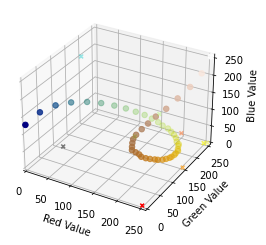

In [4]:
def hex_to_RGB(hex):
    ''' "#FFFFFF" -> [255,255,255] '''
    # Pass 16 to the integer function for change of base
    return [int(hex[i:i+2], 16) for i in range(1,6,2)]


def RGB_to_hex(RGB):
    ''' [255,255,255] -> "#FFFFFF" '''
    # Components need to be integers for hex to make sense
    RGB = [int(x) for x in RGB]
    return "#"+"".join(["0{0:x}".format(v) if v < 16 else
                        "{0:x}".format(v) for v in RGB])

def color_dict(gradient):
    ''' Takes in a list of RGB sub-lists and returns dictionary of
        colors in RGB and hex form for use in a graphing function
        defined later on '''
    return {"hex": [RGB_to_hex(RGB) for RGB in gradient],
            "r":   [RGB[0] for RGB in gradient],
            "g":   [RGB[1] for RGB in gradient],
            "b":   [RGB[2] for RGB in gradient]}

def control_points_from_colors(gradient):
    return {"hex": [RGB_to_hex(RGB) for RGB in gradient],
            "r":   [RGB[0] for RGB in gradient],
            "g":   [RGB[1] for RGB in gradient],
            "b":   [RGB[2] for RGB in gradient]}

def plot_gradient_series(color_dict, pointsize=100, control_points=None, filename=None):
        ''' Take a dictionary containing the color
            gradient in RBG and hex form and plot
            it to a 3D matplotlib device '''

        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        xcol = color_dict["r"]
        ycol = color_dict["g"]
        zcol = color_dict["b"]

        # If bezier control points passed to function,
        # plot along with curve
        if control_points != None:
            xcntl = control_points["r"]
            ycntl = control_points["g"]
            zcntl = control_points["b"]
            ax.scatter( xcntl, ycntl, zcntl,
                        c=control_points["hex"],
                        s=pointsize/2, marker='x')

        # We can pass a vector of colors corresponding to each point
        ax.scatter(xcol, ycol, zcol, c=color_dict["hex"], s=pointsize)

        ax.set_xlabel('Red Value')
        ax.set_ylabel('Green Value')
        ax.set_zlabel('Blue Value')
        ax.set_zlim3d(0,255)
        plt.ylim(0,255)
        plt.xlim(0,255)

        if not filename is None:
            # Save two views of each plot
            ax.view_init(elev=15, azim=68)
            plt.savefig(filename + ".svg")
            ax.view_init(elev=15, azim=28)
            plt.savefig(filename + "_view_2.svg")

        # Show plot for testing
        plt.show()

plot_gradient_series(color_dict(gradient),
                     pointsize=30,
                     control_points=control_points_from_colors(ref_colors)
                    )

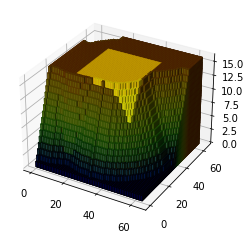

In [77]:
border = 16
#border = 2

src_base_w = 32
src_base_h = 32
max_hlevel = 16

voxels = np.zeros((src_base_w + 2*border, src_base_h + 2*border, max_hlevel), dtype=bool)
colors = np.zeros((src_base_w + 2*border, src_base_h + 2*border, max_hlevel) + (4,))

h0 = src_base_w / 2. + border
v0 = src_base_h / 2. + border

points = [
    (0, 0),
    (1, 1),
    (-1, 0),
    (0, 1),
]

for voff in range(src_base_h + 2*border):
    for hoff in range(src_base_w + 2*border):
        ur = (float(hoff) - h0) / float(src_base_w)
        vr = (float(voff) - v0) / float(src_base_h)

        hlevel = 0
        for up, vp in points:
            u = (ur - up)
            v = (vr - vp)
            d = math.sqrt(u*u + v*v)
            hlevel += max(0, 2.0 - d * 2.0)

        hlevel = min(max_hlevel, max(0, int(hlevel * 16)))
        #hlevel = int(hlevel * 16)
        for z in range(min(max_hlevel, hlevel + 1)):
            cidx = int(1.0 * hlevel / max_hlevel * (len(gradient)//2)) + 0 * (len(gradient)//2)
            rgba = gradient[cidx]
            voxels[hoff, voff, z] = bool(1)
            if hoff >= border and hoff < src_base_w + border and \
               voff >= border and voff < src_base_h + border:
                colors[hoff, voff, z] = (rgba[0]/255., rgba[1]/255., rgba[2]/255., 1.0)
            else:
                colors[hoff, voff, z] = (rgba[0]/255./2, rgba[1]/255./2, rgba[2]/255./2, 1.0)

ax = plt.figure().add_subplot(projection='3d')
ax.voxels(voxels,
              facecolors=colors,
              edgecolors=np.clip(2*colors - 0.5, 0, 1),  # brighter
              linewidth=0.5)
plt.show()


In [84]:
import numpy as np
from bisect import bisect_left

def computeACoeff(x1, x2, y1, y2, k):
    return k*(x2 - x1) - (y2 -y1)

def computeBCoeff(x1, x2, y1, y2, k):
    return -k*(x2 - x1) + (y2 -y1)

def findLowerBound(xvalues, x):
    if xvalues[-1] == x:
        return len(xvalues) - 2
    left = bisect_left(xvalues, x)
    if left >= len(xvalues):
        return len(xvalues) - 1
    if (xvalues[left]==x):
        return 0 if left == 0 else left - 1
    return left - 1

class CubicSplineStruct:
    def __init__(self):
        self.m_n = 0
        self.m_xvalues = []
        self.m_yvalues = []
        self.m_kMatrix = np.matrix(np.zeros(shape=(0,0)))
        self.m_yMatrix = np.matrix(np.zeros(shape=(0,0)))
        self.m_ytoKMatrix = np.matrix(np.zeros(shape=(0,0)))
        self.m_kCoeffs = []
    def pushFirstEquationToKMatrix(self, x0, x1):
        self.m_kMatrix[0, 0] = 2./(x1 - x0)
        self.m_kMatrix[0, 1] = 1./(x1 - x0)
    def pushLastEquationToKMatrix(self, xnm1, xn):
        self.m_kMatrix[-1, -1] = 2./(xn - xnm1)
        self.m_kMatrix[-1, -2] = 1./(xn - xnm1)
    def pushMiddleEquationToKMatrix(self, i, xim1, xi, xip1):
        self.m_kMatrix[i, i-1] = 1./(xi - xim1)
        self.m_kMatrix[i, i] = 2./(xi - xim1) + 2./(xip1 - xi)
        self.m_kMatrix[i, i + 1] = 1./(xip1 - xi)
    def computeKMatrix(self):
        self.m_kMatrix = np.matrix(np.zeros(shape=(self.m_n, self.m_n)))
        self.pushFirstEquationToKMatrix(self.m_xvalues[0], self.m_xvalues[1])
        for i in range(1, self.m_n-1):
            self.pushMiddleEquationToKMatrix(i, self.m_xvalues[i-1], self.m_xvalues[i], self.m_xvalues[i+1])
        self.pushLastEquationToKMatrix(self.m_xvalues[-2], self.m_xvalues[-1])
    def pushFirstEquationToYMatrix(self, x0, x1):
        self.m_yMatrix[0, 0] = -3./(x1 - x0)**2
        self.m_yMatrix[0, 1] = 3./(x1 - x0)**2
    def pushLastEquationToYMatrix(self, xnm1, xn):
        self.m_yMatrix[-1, -1] = 3./(xn - xnm1)**2
        self.m_yMatrix[-1, -2] = -3./(xn - xnm1)**2

    def pushMiddleEquationToYMatrix(self, i, xim1, xi, xip1):
        self.m_yMatrix[i, i-1] = -3./(xi - xim1)**2
        self.m_yMatrix[i, i] = 3./(xi - xim1)**2 - 3./(xip1 - xi)**2
        self.m_yMatrix[i, i + 1] = 3./(xip1 - xi)**2
    def computeYMatrix(self):
        self.m_yMatrix = np.matrix(np.zeros(shape=(self.m_n, self.m_n)))
        self.pushFirstEquationToYMatrix(self.m_xvalues[0], self.m_xvalues[1])
        for i in range(1, self.m_n-1):
            self.pushMiddleEquationToYMatrix(i, self.m_xvalues[i-1], self.m_xvalues[i], self.m_xvalues[i+1])
        self.pushLastEquationToYMatrix(self.m_xvalues[-2], self.m_xvalues[-1])
    def computeYtoKMatrix(self):
        self.computeKMatrix()
        self.computeYMatrix()
        self.m_ytoKMatrix = self.m_kMatrix.I*self.m_yMatrix
    def computeKCoeffs(self):
        kCoeffs = np.array(self.m_yvalues)*self.m_ytoKMatrix.T
        self.m_kCoeffs = [kCoeffs[0, i] for i in range(self.m_n)]
    def interpolateOnInterval(self, intervalIndex, x):
        x1 = self.m_xvalues[intervalIndex]
        x2 = self.m_xvalues[intervalIndex+1]
        y1 = self.m_yvalues[intervalIndex]
        y2 = self.m_yvalues[intervalIndex+1]
        t = (x - x1)/(x2 - x1)
        a = computeACoeff(x1, x2, y1, y2, self.m_kCoeffs[intervalIndex])
        b = computeBCoeff(x1, x2, y1, y2, self.m_kCoeffs[intervalIndex+1])
        return (1-t)*y1 + t*y2 + t*(1-t)*(a*(1-t)+b*t)
    def interpolate(self, x):
        if len(self.m_xvalues) == 0:
            return 0.
        intervalLowerBound = findLowerBound(self.m_xvalues, x)
        return self.interpolateOnInterval(intervalLowerBound, x)


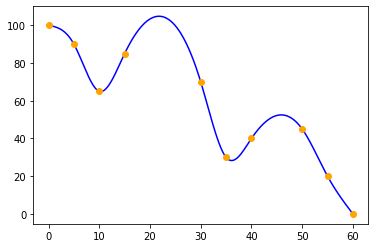

In [95]:
x_values = [0,5,10,15,30,35,40,50,55,60]
y_values = [100,90,65,85,70,30,40,45,20,0]

cubicSplineStruct = CubicSplineStruct()
cubicSplineStruct.m_n = len(x_values)
cubicSplineStruct.m_xvalues =  x_values
cubicSplineStruct.computeYtoKMatrix()
cubicSplineStruct.m_yvalues = y_values
cubicSplineStruct.computeKCoeffs()

new_x_values = [x * 0.1 for x in range(0, 600)]
new_y_values = [cubicSplineStruct.interpolate(x) for x in new_x_values]

plt.plot(new_x_values, new_y_values, '-b')
plt.plot(x_values, y_values, 'o', color='orange')
plt.show()

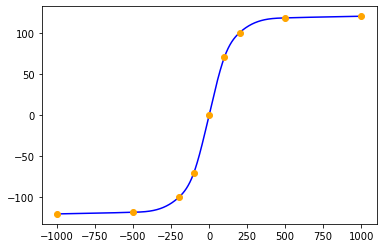

In [166]:


hlevels_ref_x = [-1000, -500, -200, -100, 0, 100, 200, 500, 1000]
hlevels_ref_y = [-120, -118, -100, -70, 0, 70, 100, 118,120]

hlevels_spline = CubicSplineStruct()
hlevels_spline.m_n = len(hlevels_ref_x)
hlevels_spline.m_xvalues =  hlevels_ref_x
hlevels_spline.computeYtoKMatrix()
hlevels_spline.m_yvalues = hlevels_ref_y
hlevels_spline.computeKCoeffs()

x_steps = 10
hlevels_x = [x / x_steps for x in range(min(hlevels_ref_x) * x_steps, max(hlevels_ref_x) * x_steps)]
hlevels_y = [hlevels_spline.interpolate(x) for x in hlevels_x]

plt.plot(hlevels_x, hlevels_y, '-b')
plt.plot(hlevels_ref_x, hlevels_ref_y, 'o', color='orange')
plt.show()

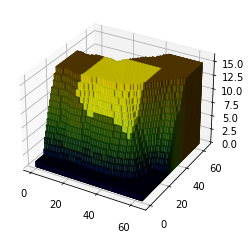

In [195]:
border = 16
#border = 2

src_base_w = 32
src_base_h = 32
max_hlevel = 16

voxels = np.zeros((src_base_w + 2*border, src_base_h + 2*border, max_hlevel), dtype=bool)
colors = np.zeros((src_base_w + 2*border, src_base_h + 2*border, max_hlevel) + (4,))

h0 = src_base_w / 2. + border
v0 = src_base_h / 2. + border

points = [
    (0, 0),
    (1, 1), (0.5, 0.5),
    (-1, 0),
    #(0, 1),
]

for voff in range(src_base_h + 2*border):
    for hoff in range(src_base_w + 2*border):
        ur = (float(hoff) - h0) / float(src_base_w)
        vr = (float(voff) - v0) / float(src_base_h)

        hlevel = 0
        for up, vp in points:
            u = (ur - up)
            v = (vr - vp)
            d_euc = math.sqrt(u*u + v*v)
            d_max = max(abs(u), abs(v))
            d = ( d_euc + d_max ) / 2.0
            hlevel += max(0, 1.6 - d * 2.0)

        hlevel = min(1.0, max(0.0, hlevel))
        hlevel = hlevels_spline.interpolate(hlevel * 100.0 * 1.5) / 100.0

        hlevel = min(max_hlevel, max(0, int(hlevel * 16)))
        #hlevel = int(hlevel * 16)
        for z in range(min(max_hlevel, hlevel + 1)):
            cidx = int(1.0 * hlevel / max_hlevel * (len(gradient)//2)) + 0 * (len(gradient)//2)
            rgba = gradient[cidx]
            voxels[hoff, voff, z] = bool(1)
            if hoff >= border and hoff < src_base_w + border and \
               voff >= border and voff < src_base_h + border:
                colors[hoff, voff, z] = (rgba[0]/255., rgba[1]/255., rgba[2]/255., 1.0)
            else:
                colors[hoff, voff, z] = (rgba[0]/255./2, rgba[1]/255./2, rgba[2]/255./2, 1.0)

ax = plt.figure().add_subplot(projection='3d')
ax.voxels(voxels,
              facecolors=colors,
              edgecolors=np.clip(2*colors - 0.5, 0, 1),  # brighter
              linewidth=0.5)
plt.show()


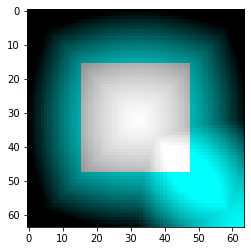

(0, 0, 0, 255)
(0, 0, 0, 255)
(0, 0, 0, 255)
(0, 252, 252, 255)
(0, 0, 0, 255)
(0, 0, 0, 255)


In [423]:
src_base_w = 32
src_base_h = 32

border = 16

h0 = src_base_w / 2. + border
v0 = src_base_h / 2. + border

for id in [
    0,
]:
    points = [
        (0.0, 0.0, 1.0, 0.5, 1, 1),
        #(0.5, 0.5, 0.5, 0.76, 1, 0),
        (1.0, 1.0, 1.0, 0.5, 1, 1),
        #(-1, 0),
        #(0, 1),
    ]

    img = Image.new('RGBA', (src_base_w + border * 2, src_base_h + border * 2), (0, 0, 0, 0))
    pixels = img.load()

    for voff in range(src_base_h + 2*border):
        for hoff in range(src_base_w + 2*border):

            ur = (float(hoff) - h0) / float(src_base_w)
            vr = (float(voff) - v0) / float(src_base_h)
            
            hlevel = 0
            for up, vp, mx, pd, fdeuc, fdmax in points:
                u = (ur - up)
                v = (vr - vp)
                d_euc = math.sqrt(u*u + v*v)
                d_max = max(abs(u), abs(v))
                #d = d_euc * 2

                #d = 2.0 * ( d_euc + d_max ) / 3.0
                #hlevel += max(0, 1.0 - d * 0.75)

                #d = 2.0 * ( d_euc + d_max *2 ) / 3.0
                #hlevel += max(0, 1.0 - d * 0.5)

                #d = 2.0 * ( d_euc + d_max ) / 2.0
                #i = max(0, 1.0 - d * 0.5)
                #hlevel += hlevels_spline.interpolate(i * 2 * 100.0) / 100.0

                d = d_euc * fdeuc + d_max * fdmax
                i = max(0, mx - d * pd)
                hlevel += hlevels_spline.interpolate(i * 2 * 100.0) / 100.0

            #hlevel = min(1.0, max(0.0, hlevel))
            #hlevel = hlevels_spline.interpolate(hlevel * 100.0) / 100.0

            hlevel = min(1, max(0, hlevel))

            if hoff >= border and hoff < src_base_w + border and \
               voff >= border and voff < src_base_h + border:
                r, g, b = hlevel * 128, hlevel * 128, hlevel * 128
            else:
                r, g, b = hlevel * 0, hlevel * 128, hlevel * 128

            f = 2
            pixels[hoff, voff] = ( int(r * f), int(g * f), int(b * f), int(255) )

    plt.imshow(img)
    plt.show()

print(img.getpixel((0, 0)))
print(img.getpixel((src_base_w + 2*border - 1, 0)))
print(img.getpixel((0, src_base_h + 2*border - 1)))
print(img.getpixel((src_base_w + 2*border - 1, src_base_h + 2*border - 1)))

print(img.getpixel((src_base_w / 2 + border - 1, 0)))
print(img.getpixel((0, src_base_h / 2 + border - 1)))


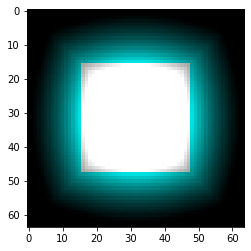

(0, 0, 0, 255)
(0, 0, 0, 255)
(0, 0, 0, 255)
(0, 0, 0, 255)
(0, 0, 0, 255)
(0, 0, 0, 255)


In [502]:
src_base_w = 32
src_base_h = 32

border = 16

h0 = src_base_w / 2. + border - 0.5
v0 = src_base_h / 2. + border - 0.5

for id in [
    0,
]:

    points = [
        (0, 0),
        #(1, 1),
        #(-1, 0),
        #(0, 1),
    ]

    img = Image.new('RGBA', (src_base_w + border * 2, src_base_h + border * 2), (0, 0, 0, 0))
    pixels = img.load()

    for voff in range(src_base_h + 2*border):
        for hoff in range(src_base_w + 2*border):

            ur = (float(hoff) - h0) / float(src_base_w)
            vr = (float(voff) - v0) / float(src_base_h)
            
            hlevel = 0
            for up, vp in points:
                u = (ur - up)
                v = (vr - vp)
                d_euc = math.sqrt(u*u + v*v)
                d_max = max(abs(u), abs(v))
                d = ( d_euc + d_max ) / 2.0
                
                #i = max(0, 1.0 - d * d * 1.0)
                #hlevel += hlevels_spline.interpolate(i * 2 * 100.0) / 100.0
                #hlevel += i

                if d != 0:
                    i = min(1.0, max(0, 1.0 / math.pow(d, 1.0) / 1.0 - 1.05 ))
                else:
                    i = 1.0
                hlevel += i
                    
            #hlevel = min(1.0, max(0.0, hlevel))
            #hlevel = hlevels_spline.interpolate(hlevel * 100.0) / 100.0

            hlevel = min(1, max(0, hlevel))
            #hlevel = hlevels_spline.interpolate(hlevel * 100.0) / 100.0

            if hoff >= border and hoff < src_base_w + border and \
               voff >= border and voff < src_base_h + border:
                r, g, b = hlevel * 128, hlevel * 128, hlevel * 128
            else:
                r, g, b = hlevel * 0, hlevel * 128, hlevel * 128

            f = 2
            pixels[hoff, voff] = ( int(r * f), int(g * f), int(b * f), int(255) )

    plt.imshow(img)
    plt.show()

print(img.getpixel((0, 0)))
print(img.getpixel((src_base_w + 2*border - 1, 0)))
print(img.getpixel((0, src_base_h + 2*border - 1)))
print(img.getpixel((src_base_w + 2*border - 1, src_base_h + 2*border - 1)))

print(img.getpixel((src_base_w / 2 + border - 1, 0)))
print(img.getpixel((0, src_base_h / 2 + border - 1)))


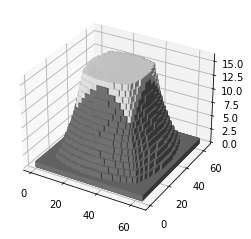

In [503]:
    voxels = np.zeros((src_base_w + 2*border, src_base_h + 2*border, max_hlevel), dtype=bool)
    colors = np.zeros((src_base_w + 2*border, src_base_h + 2*border, max_hlevel) + (4,))

    for voff in range(src_base_h + 2*border):
        for hoff in range(src_base_w + 2*border):
            rmap, gmap, bmap, amap = img.getpixel((hoff, voff))
            vmap = max(rmap, gmap, bmap) # Convert to Grey
            if vmap <= 1: vmap = 0
            hlevel = int(vmap / 16)

            for z in range(hlevel + 1):
                voxels[hoff, voff, z] = bool(1)
                
                if hoff >= border and hoff < src_base_w + border and \
                   voff >= border and voff < src_base_h + border:
                        colors[hoff, voff, z] = (1.0, 1.0, 1.0, 1.0)
                else:
                        colors[hoff, voff, z] = (0.5, 0.5, 0.5, 1.0)

    ax = plt.figure().add_subplot(projection='3d')
    ax.voxels(voxels,
              facecolors=colors,
              edgecolors=np.clip(2*colors - 0.5, 0, 1),  # brighter
              linewidth=0.5)
    plt.show()
